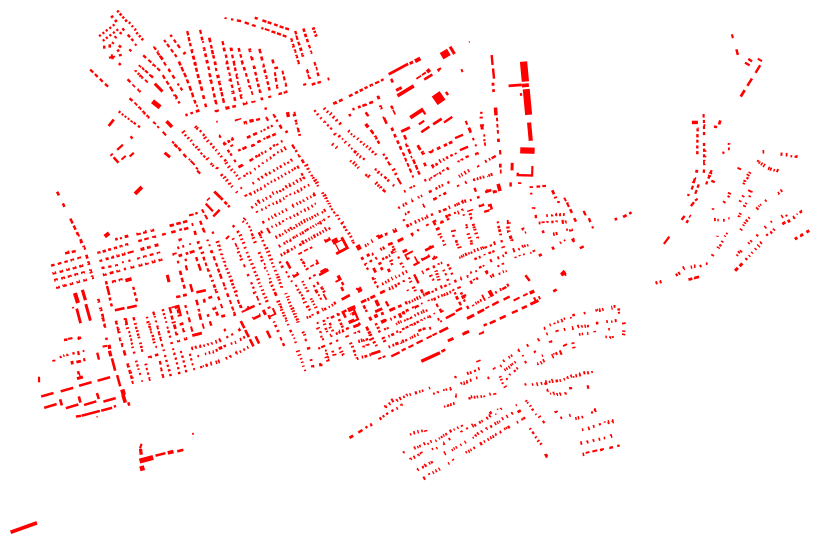

In [115]:
from pathlib import Path
import osmnx as ox

place = 'Озинки'
dpi = 1000

width, height = 768, 768

base_dir = Path.cwd() / 'output' / 'research'
base_dir.mkdir(parents=True, exist_ok=True)

buildings_path = base_dir / 'buildings.svg'
driving_path = base_dir / 'drive.svg'
walking_path = base_dir / 'walking.svg'

output_path = base_dir / '1_output.svg'

transparent = (0, 0, 0, 0)

gfeatures = ox.features_from_place(place, tags={'building': True})

bbox_raw = gfeatures.total_bounds  #  minx, miny, maxx, maxy
bbox = [bbox_raw[3], bbox_raw[1], bbox_raw[2], bbox_raw[0]]

fig1, ax1 = ox.plot_footprints(
    gfeatures,
    save=True,
    filepath=buildings_path,
    dpi=dpi,
    bbox=tuple(bbox),
    bgcolor='#000000',
    color='red'
)

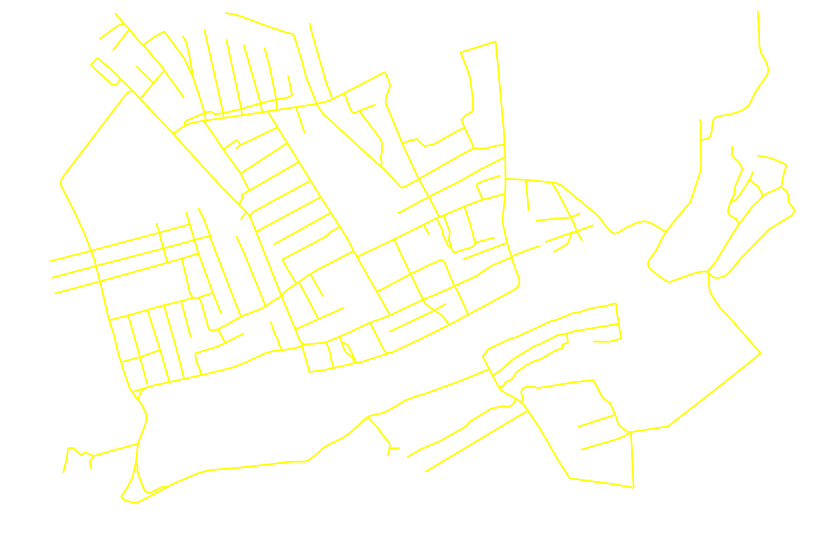

In [116]:
# groutes = ox.graph_from_place(place, network_type='drive')
groutes = ox.graph_from_bbox(*bbox, network_type='drive')
fig2, ax2 = ox.plot_graph(
    groutes,
    node_size=0, save=True, filepath=driving_path, dpi=dpi,
    bbox=bbox,
    bgcolor=transparent,
    edge_color='#FFFF00'
)

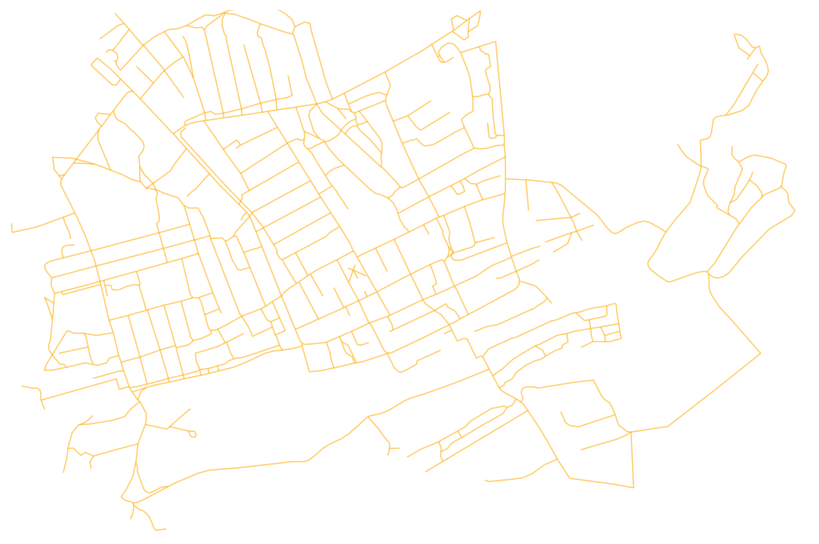

In [117]:
# gbike = ox.graph_from_place(place, network_type='walk')
gbike = ox.graph_from_bbox(*bbox, network_type='walk')
fig3, ax3 = ox.plot_graph(
    gbike,
    node_size=0, save=True, filepath=walking_path, dpi=dpi,
    bbox=bbox,
    bgcolor=transparent,
    edge_color='#FFAA00',
    edge_alpha=0.3
)

In [118]:
import io
import svglib.svglib as svglib
from reportlab.graphics.shapes import Drawing
from reportlab.graphics.renderSVG import drawToFile

import xml.etree.ElementTree as ET


def find_by_id(element, id_):
    for child in element:
        if child.get('id') == id_:  # replace 'id' with your attribute name
            return child
        result = find_by_id(child, id_)
        if result is not None:
            return result
    return None


svg_drive = svglib.svg2rlg(driving_path)
svg_walk = svglib.svg2rlg(walking_path)
svg_building = svglib.svg2rlg(buildings_path)

d = Drawing(width, height)  # setting the width and height

d.add(svg_building)
d.add(svg_drive)
d.add(svg_walk)

drawToFile(d, output_path)

filter_element = ET.fromstring("""
<defs xmlns="http://www.w3.org/2000/svg">
    <filter id="glow">
        <feGaussianBlur stdDeviation="1.5" result="coloredBlur"/>
        <feMerge>
            <feMergeNode in="coloredBlur"/>
            <feMergeNode in="SourceGraphic"/>
        </feMerge>
    </filter>
    <filter id="hardglow">
        <feGaussianBlur stdDeviation="0.5" result="coloredBlur"/>
        <feMerge>
            <feMergeNode in="coloredBlur"/>
            <feMergeNode in="SourceGraphic"/>
        </feMerge>
    </filter>
</defs>
""")

tree = ET.parse(output_path)
root = tree.getroot()

new_background = '#000000'

for element in root.iter():
    if element.tag.endswith('svg') or element.tag.endswith('rect'):
        element.set('fill', new_background)

root.insert(1, filter_element)

parent_element = find_by_id(root, 'group')[0]
buildings_element = parent_element[0]
drive_element = parent_element[1]
walk_element = parent_element[2]

buildings_element.set('style', 'filter:url(#hardglow)')

tree.write(output_path)